**Import the necessary libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
# load the data
path = os.getcwd()
daily_ny = pd.read_csv(path + '/daily_data_NewYork.csv')
mobility_ny = pd.read_csv(path + '/NewYork_mobility.csv')

**Data Preparation**

In [3]:
# focus on areas of intereset
mobility_ny = mobility_ny[['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline']]
daily_ny = daily_ny[['date_of_interest', 'CASE_COUNT']]
daily_ny = daily_ny.rename(columns={'date_of_interest':'date'})

# match datetime format
mobility_ny['date'] = pd.to_datetime(mobility_ny.date)
daily_ny['date'] = pd.to_datetime(daily_ny.date)
print(mobility_ny.shape)
print(daily_ny.shape)

(53802, 4)
(855, 2)


In [4]:
# merge the dataframes
df = mobility_ny.merge(daily_ny, how='left', on='date')
df = df.dropna().reset_index()
df = df.drop(columns='index')

print(df.shape)
print(df.columns)

(26776, 5)
Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline', 'CASE_COUNT'],
      dtype='object')


**Exploratory Data Analysis**

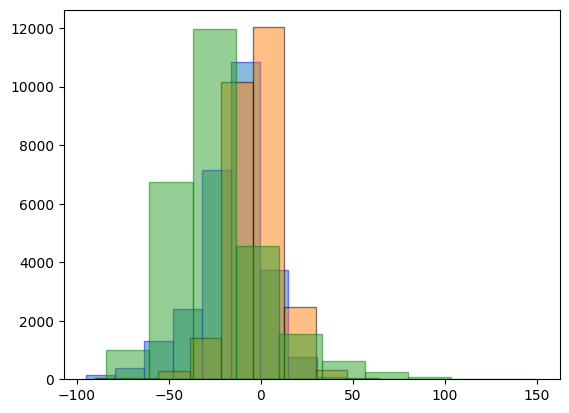

In [28]:
plt.hist(df.retail_and_recreation_percent_change_from_baseline, alpha=0.5, edgecolor='blue')
plt.hist(df.grocery_and_pharmacy_percent_change_from_baseline, alpha=0.5, edgecolor='black')
plt.hist(df.transit_stations_percent_change_from_baseline, alpha=0.5, edgecolor='green')
plt.show()

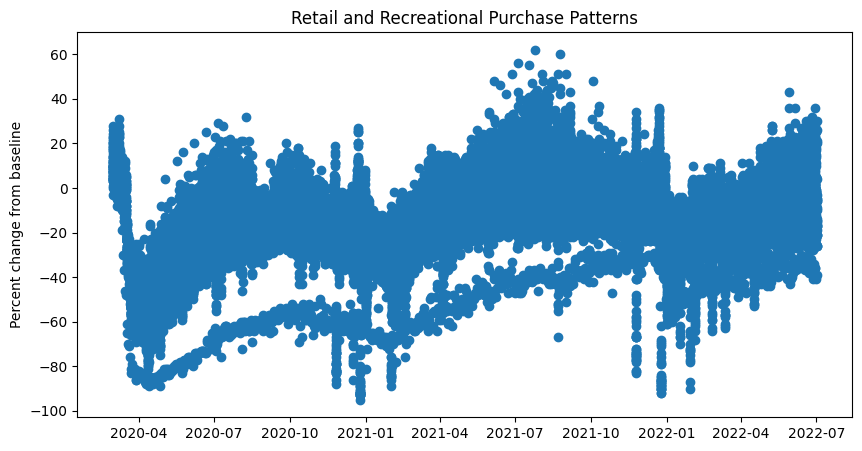

In [57]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.retail_and_recreation_percent_change_from_baseline)
plt.title('Retail and Recreational Purchase Patterns')
plt.ylabel('Percent change from baseline')
plt.show()

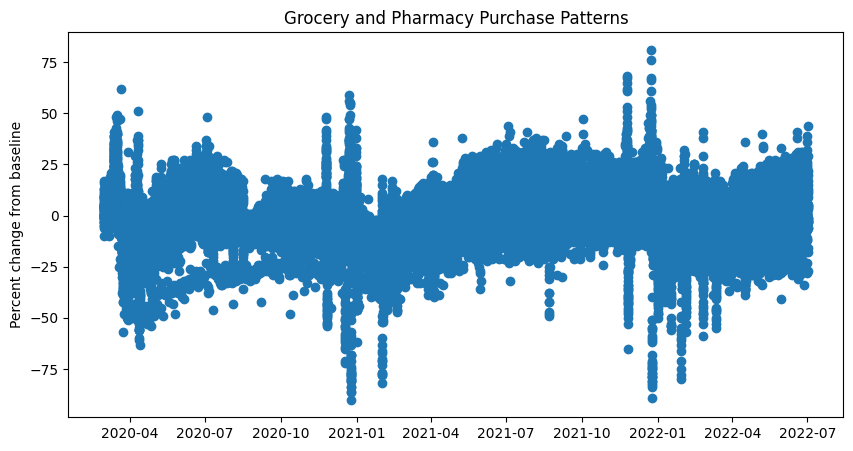

In [58]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.grocery_and_pharmacy_percent_change_from_baseline)
plt.title('Grocery and Pharmacy Purchase Patterns')
plt.ylabel('Percent change from baseline')
plt.show()

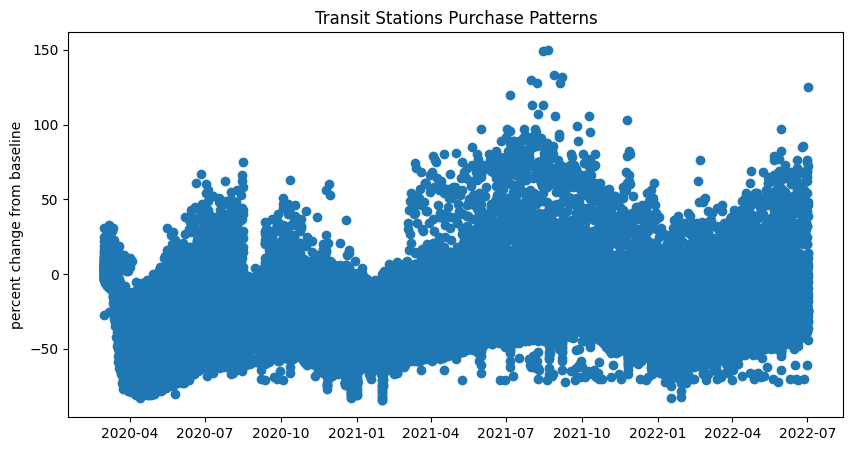

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.transit_stations_percent_change_from_baseline)
plt.title('Transit Stations Purchase Patterns')
plt.ylabel('percent change from baseline')
plt.show()

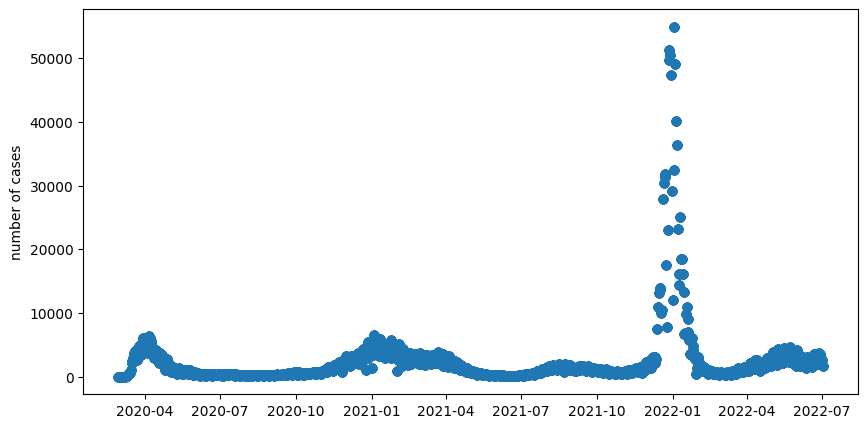

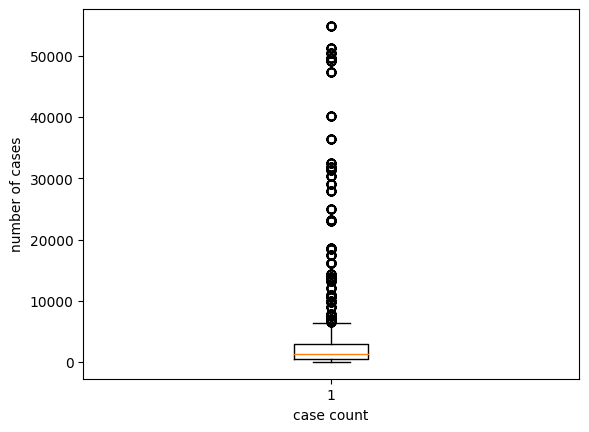

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(df.date, df.CASE_COUNT)
plt.ylabel('number of cases')
plt.show()

plt.boxplot(df.CASE_COUNT)
plt.ylabel('number of cases')
plt.xlabel('case count')
plt.show()

In [ ]:
# feature engineering
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['year'] = df.date.dt.year
df['lag_1'] = df.CASE_COUNT.shift(1)
df['monthly_average'] = df.groupby(df['date'].dt.to_period('M'))['CASE_COUNT'].transform('mean')
df['weekly_average'] = df.groupby(df['date'].dt.to_period('W'))['CASE_COUNT'].transform('mean')
df['weekly_moving_average'] = df['CASE_COUNT'].rolling(window=7, min_periods=1).mean()
df['exponential_moving_average'] = df['CASE_COUNT'].ewm(span=7, adjust=False).mean()

# accomodate the lag_1 column by removing the first row
df = df.iloc[1:]

In [ ]:
# preprocess and split the data
features = ['month', 'day', 'year', 'CASE_COUNT', 'lag_1', 'monthly_average', 'weekly_average', 'weekly_moving_average', 'exponential_moving_average']
X = df[features]
y = df['retail_and_recreation_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1)

In [ ]:
# use naive baseline model
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))

In [ ]:
# create the model
r_model = RandomForestRegressor()
r_model.fit(X_train, y_train)

r_preds = cross_val_predict(r_model, X_valid, y_valid, cv=5)
r_mae = metrics.mean_absolute_error(y_valid, r_preds)
r_mse = metrics.mean_squared_error(y_valid, r_preds)
print('Mean Absolute Error: %f'%(r_mae))
print('Mean Squared Error: %f'%(r_mse))

In [ ]:
# evaluate spending changes in the grocery and pharmacy department
X = df[features]
y = df['grocery_and_pharmacy_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

# set the baseline metrics
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)

print('Baseline Metrics')
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))
print('--------------------------------------------')

# create the model
g_model = RandomForestRegressor()
g_model.fit(X_train, y_train)

g_preds = cross_val_predict(g_model, X_valid, y_valid, cv=5)
g_mae = metrics.mean_absolute_error(y_valid, g_preds)
g_mse = metrics.mean_squared_error(y_valid, g_preds)
print('Mean Absolute Error: %f'%(g_mae))
print('Mean Squared Error: %f'%(g_mse))

In [ ]:
# evaluate spending changes in the transit department
X = df[features]
y = df['transit_stations_percent_change_from_baseline']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

# set the baseline metrics
baseline = y.mean()
baseline_predictions = [baseline] * len(X)

base_mae = metrics.mean_absolute_error(y, baseline_predictions)
base_mse = metrics.mean_squared_error(y, baseline_predictions)

print('Baseline Metrics')
print('Mean Absolute Error: %f'%(base_mae))
print('Mean Squared Error: %f'%(base_mse))
print('--------------------------------------------')

# create the model
t_model = RandomForestRegressor()
t_model.fit(X_train, y_train)

t_preds = cross_val_predict(t_model, X_valid, y_valid, cv=5)
t_mae = metrics.mean_absolute_error(y_valid, t_preds)
t_mse = metrics.mean_squared_error(y_valid, t_preds)
print('Mean Absolute Error: %f'%(t_mae))
print('Mean Squared Error: %f'%(t_mse))